In [1]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import os
import math
import copy

In [2]:
import torch
import torch.nn as nn
from torch.utils import data
import torch.nn.functional as F

import torchvision.transforms as transforms
import torchvision.models as models

In [5]:
device = torch.device("cuda")

## Image to Tensor Conversions

In [57]:
imsize = 1024

def file_to_tensor(file_path):
    image = Image.open(file_path)
    ten_image = transforms.Compose([transforms.Resize(imsize), transforms.ToTensor()])(image).to(device)
    ten_image.unsqueeze_(0) # adds batch size = 1
    return ten_image

def image_to_tensor(image):
    ten_image = transforms.Compose([transforms.Resize(imsize), transforms.ToTensor()])(image).to(device)
    ten_image.unsqueeze_(0) # adds batch size = 1
    return ten_image

def tensor_to_image(tensor):
    img = transforms.ToPILImage()(tensor.clone().cpu().squeeze(0))
    return img

In [58]:
set_folder = "Set11"

content = file_to_tensor("UpdatedSets/"+set_folder+"/content.jpg")
style = file_to_tensor("UpdatedSets/"+set_folder+"/style.png")

In [59]:
if content.size() != style.size():
    print("Please execute Processing the Data.ipynb on the dataset")

## Choosing the optimal model

In [24]:
vgg = models.vgg19_bn(pretrained=True).features.to(device).eval()

# Setting Up the Normalisation Layer for VGG

In [10]:
class Normalization(nn.Module):
    def __init__(self):
        super(Normalization, self).__init__()
        self.mean = torch.tensor([0.485, 0.456, 0.406]).to(device).view(-1,1,1)
        self.std = torch.tensor([0.229, 0.224, 0.225]).to(device).view(-1,1,1)
    
    def forward(self, img):
        return (img - self.mean)/self.std

# Setting Up the Content Loss - Simple MSE Loss

In [11]:
class ContentLoss(nn.Module):
    def __init__(self, target):
        super(ContentLoss, self).__init__()
        self.target = target.detach()
    
    def forward(self, img):
        self.loss = F.mse_loss(img, self.target)
        return img

# Setting Up the Style Loss - Using Gram Matrix

In [12]:
def convert_to_gram(img):
    b, f, h, w = img.size()
    reshp_img = img.view(b*f, w*h)
    gram = torch.mm(reshp_img, reshp_img.t()).div(b*f*w*h)
    return gram

In [13]:
class StyleLoss(nn.Module):
    def __init__(self, target):
        super(StyleLoss, self).__init__()
        self.target = convert_to_gram(target).detach()
    
    def forward(self, img):
        self.loss = F.mse_loss(convert_to_gram(img), self.target)
        return img

# Create the new model

In [25]:
content_layers = ['conv_2', 'conv_5']
style_layers = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5', 'conv_7']


def get_new_model(vgg19, content_image, style_image):
    
    global content_layers
    global style_layers
    content_modules = []
    style_modules = []

    vgg = copy.deepcopy(vgg19)
    normalisation = Normalization().to(device)
    model = nn.Sequential(normalisation)
    i = 0

    for layer in vgg:
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_'+str(i)

        elif isinstance(layer, nn.ReLU):
            name = 'relu_'+str(i)

        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_'+str(i)

        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_'+str(i)

        model.add_module(name, layer)

        if name in content_layers:
            target = model(content_image).detach()
            content_l = ContentLoss(target)
            model.add_module('content_layer_'+str(i), content_l)
            content_modules.append(content_l)
        
        if name in style_layers:
            target = model(style_image).detach()
            style_l = StyleLoss(target)
            model.add_module('style_layer_'+str(i), style_l)
            style_modules.append(style_l)
        
    for i in range(len(model)-1, 0, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break
    model = model[:i+1]
    return model, content_modules, style_modules

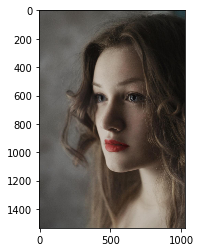

In [63]:
use_content = True
input_img = None

if use_content is True:
    # For using the content image
    input_img = tensor_to_image(content)
else:
    # For using random noise as input
    input_img = tensor_to_image(torch.randn(content.data.size(), device=device))

plt.imshow(input_img)

# Training the model

In [64]:
def style_transfer(vgg, content_img, style_img, input_img, iters=10, style_w=1000000, content_w=1):
    
    input_img = image_to_tensor(input_img)
    model, con_layers, st_layers = get_new_model(vgg, content_img, style_img)
    optimiser = torch.optim.LBFGS([input_img.requires_grad_()], lr=0.05)
    
    for i in range(iters):
        
        def closure():
            input_img.data.clamp_(0, 1)
            model(input_img)
            style_val = 0
            content_val = 0
            
            optimiser.zero_grad()

            for sc in st_layers:
                style_val += sc.loss
            for cc in con_layers:
                content_val += cc.loss

            net_loss = style_w*style_val + content_w*content_val
            net_loss.backward()
            print('Iteration {}: '.format(i+1), 'Style Loss = {:4f} '.format(style_val),
              'Content Loss = {:4f} '.format(content_val))
            return net_loss
            
        optimiser.step(closure)

    input_img.data.clamp_(0, 1)
    final_img = tensor_to_image(input_img)
    plt.imshow(final_img)
    return final_img

In [ ]:
output = style_transfer(vgg, content, style, input_img, iters=100, style_w=50000000, content_w=10)
output.save("UpdatedSets/"+set_folder+"/output_large.png")

Iteration 1:  Style Loss = 0.000016  Content Loss = 0.000000 
Iteration 1:  Style Loss = 0.000016  Content Loss = 0.000000 
Iteration 1:  Style Loss = 0.000016  Content Loss = 0.000000 
Iteration 1:  Style Loss = 0.000016  Content Loss = 0.000368 
Iteration 1:  Style Loss = 0.000015  Content Loss = 0.005087 
Iteration 1:  Style Loss = 0.000013  Content Loss = 0.018659 
Iteration 1:  Style Loss = 0.000012  Content Loss = 0.039099 
Iteration 1:  Style Loss = 0.000011  Content Loss = 0.058233 
Iteration 1:  Style Loss = 0.000010  Content Loss = 0.075710 
Iteration 1:  Style Loss = 0.000009  Content Loss = 0.091195 
Iteration 1:  Style Loss = 0.000008  Content Loss = 0.104500 
Iteration 1:  Style Loss = 0.000008  Content Loss = 0.116506 
Iteration 1:  Style Loss = 0.000007  Content Loss = 0.127133 
Iteration 1:  Style Loss = 0.000007  Content Loss = 0.136597 
Iteration 1:  Style Loss = 0.000006  Content Loss = 0.144975 
Iteration 1:  Style Loss = 0.000006  Content Loss = 0.152557 
Iteratio

Iteration 7:  Style Loss = 0.000000  Content Loss = 0.196502 
Iteration 7:  Style Loss = 0.000000  Content Loss = 0.196499 
Iteration 7:  Style Loss = 0.000000  Content Loss = 0.196491 
Iteration 7:  Style Loss = 0.000000  Content Loss = 0.196476 
Iteration 7:  Style Loss = 0.000000  Content Loss = 0.196458 
Iteration 7:  Style Loss = 0.000000  Content Loss = 0.196434 
Iteration 7:  Style Loss = 0.000000  Content Loss = 0.196406 
Iteration 8:  Style Loss = 0.000000  Content Loss = 0.196374 
Iteration 8:  Style Loss = 0.000000  Content Loss = 0.196339 
Iteration 8:  Style Loss = 0.000000  Content Loss = 0.196300 
Iteration 8:  Style Loss = 0.000000  Content Loss = 0.196258 
Iteration 8:  Style Loss = 0.000000  Content Loss = 0.196212 
Iteration 8:  Style Loss = 0.000000  Content Loss = 0.196165 
Iteration 8:  Style Loss = 0.000000  Content Loss = 0.196113 
Iteration 8:  Style Loss = 0.000000  Content Loss = 0.196060 
Iteration 8:  Style Loss = 0.000000  Content Loss = 0.196003 
Iteratio

Iteration 14:  Style Loss = 0.000000  Content Loss = 0.191205 
Iteration 14:  Style Loss = 0.000000  Content Loss = 0.191097 
Iteration 14:  Style Loss = 0.000000  Content Loss = 0.190985 
Iteration 14:  Style Loss = 0.000000  Content Loss = 0.190868 
Iteration 14:  Style Loss = 0.000000  Content Loss = 0.190747 
Iteration 14:  Style Loss = 0.000000  Content Loss = 0.190621 
Iteration 14:  Style Loss = 0.000000  Content Loss = 0.190492 
Iteration 14:  Style Loss = 0.000000  Content Loss = 0.190359 
Iteration 14:  Style Loss = 0.000000  Content Loss = 0.190224 
Iteration 14:  Style Loss = 0.000000  Content Loss = 0.190086 
Iteration 14:  Style Loss = 0.000000  Content Loss = 0.189947 
Iteration 14:  Style Loss = 0.000000  Content Loss = 0.189806 
Iteration 14:  Style Loss = 0.000000  Content Loss = 0.189666 
Iteration 14:  Style Loss = 0.000000  Content Loss = 0.189527 
Iteration 14:  Style Loss = 0.000000  Content Loss = 0.189388 
Iteration 14:  Style Loss = 0.000000  Content Loss = 0.

Iteration 20:  Style Loss = 0.000000  Content Loss = 0.184383 
Iteration 20:  Style Loss = 0.000000  Content Loss = 0.184324 
Iteration 20:  Style Loss = 0.000000  Content Loss = 0.184265 
Iteration 20:  Style Loss = 0.000000  Content Loss = 0.184206 
Iteration 20:  Style Loss = 0.000000  Content Loss = 0.184146 
Iteration 21:  Style Loss = 0.000000  Content Loss = 0.184086 
Iteration 21:  Style Loss = 0.000000  Content Loss = 0.184027 
Iteration 21:  Style Loss = 0.000000  Content Loss = 0.183967 
Iteration 21:  Style Loss = 0.000000  Content Loss = 0.183907 
Iteration 21:  Style Loss = 0.000000  Content Loss = 0.183848 
Iteration 21:  Style Loss = 0.000000  Content Loss = 0.183788 
Iteration 21:  Style Loss = 0.000000  Content Loss = 0.183730 
Iteration 21:  Style Loss = 0.000000  Content Loss = 0.183671 
Iteration 21:  Style Loss = 0.000000  Content Loss = 0.183614 
Iteration 21:  Style Loss = 0.000000  Content Loss = 0.183557 
Iteration 21:  Style Loss = 0.000000  Content Loss = 0.

Iteration 27:  Style Loss = 0.000000  Content Loss = 0.178305 
Iteration 27:  Style Loss = 0.000000  Content Loss = 0.178256 
Iteration 27:  Style Loss = 0.000000  Content Loss = 0.178209 
Iteration 27:  Style Loss = 0.000000  Content Loss = 0.178163 
Iteration 27:  Style Loss = 0.000000  Content Loss = 0.178118 
Iteration 27:  Style Loss = 0.000000  Content Loss = 0.178075 
Iteration 27:  Style Loss = 0.000000  Content Loss = 0.178033 
Iteration 27:  Style Loss = 0.000000  Content Loss = 0.177992 
Iteration 27:  Style Loss = 0.000000  Content Loss = 0.177954 
Iteration 27:  Style Loss = 0.000000  Content Loss = 0.177916 
Iteration 27:  Style Loss = 0.000000  Content Loss = 0.177880 
Iteration 27:  Style Loss = 0.000000  Content Loss = 0.177846 
Iteration 27:  Style Loss = 0.000000  Content Loss = 0.177813 
Iteration 27:  Style Loss = 0.000000  Content Loss = 0.177781 
Iteration 28:  Style Loss = 0.000000  Content Loss = 0.177751 
Iteration 28:  Style Loss = 0.000000  Content Loss = 0.

Iteration 33:  Style Loss = 0.000000  Content Loss = 0.175173 
Iteration 33:  Style Loss = 0.000000  Content Loss = 0.175179 
Iteration 33:  Style Loss = 0.000000  Content Loss = 0.175185 
Iteration 34:  Style Loss = 0.000000  Content Loss = 0.175192 
Iteration 34:  Style Loss = 0.000000  Content Loss = 0.175198 
Iteration 34:  Style Loss = 0.000000  Content Loss = 0.175205 
Iteration 34:  Style Loss = 0.000000  Content Loss = 0.175212 
Iteration 34:  Style Loss = 0.000000  Content Loss = 0.175219 
Iteration 34:  Style Loss = 0.000000  Content Loss = 0.175226 
Iteration 34:  Style Loss = 0.000000  Content Loss = 0.175233 
Iteration 34:  Style Loss = 0.000000  Content Loss = 0.175239 
Iteration 34:  Style Loss = 0.000000  Content Loss = 0.175245 
Iteration 34:  Style Loss = 0.000000  Content Loss = 0.175251 
Iteration 34:  Style Loss = 0.000000  Content Loss = 0.175256 
Iteration 34:  Style Loss = 0.000000  Content Loss = 0.175261 
Iteration 34:  Style Loss = 0.000000  Content Loss = 0.

Iteration 40:  Style Loss = 0.000000  Content Loss = 0.171522 
Iteration 40:  Style Loss = 0.000000  Content Loss = 0.171503 
Iteration 40:  Style Loss = 0.000000  Content Loss = 0.171483 
Iteration 40:  Style Loss = 0.000000  Content Loss = 0.171462 
Iteration 40:  Style Loss = 0.000000  Content Loss = 0.171441 
Iteration 40:  Style Loss = 0.000000  Content Loss = 0.171419 
Iteration 40:  Style Loss = 0.000000  Content Loss = 0.171396 
Iteration 40:  Style Loss = 0.000000  Content Loss = 0.171373 
Iteration 40:  Style Loss = 0.000000  Content Loss = 0.171349 
Iteration 40:  Style Loss = 0.000000  Content Loss = 0.171324 
Iteration 40:  Style Loss = 0.000000  Content Loss = 0.171298 
Iteration 40:  Style Loss = 0.000000  Content Loss = 0.171271 
Iteration 41:  Style Loss = 0.000000  Content Loss = 0.171243 
Iteration 41:  Style Loss = 0.000000  Content Loss = 0.171214 
Iteration 41:  Style Loss = 0.000000  Content Loss = 0.171184 
Iteration 41:  Style Loss = 0.000000  Content Loss = 0.

Iteration 46:  Style Loss = 0.000000  Content Loss = 0.167492 
Iteration 47:  Style Loss = 0.000000  Content Loss = 0.167462 
Iteration 47:  Style Loss = 0.000000  Content Loss = 0.167431 
Iteration 47:  Style Loss = 0.000000  Content Loss = 0.167398 
Iteration 47:  Style Loss = 0.000000  Content Loss = 0.167365 
Iteration 47:  Style Loss = 0.000000  Content Loss = 0.167331 
Iteration 47:  Style Loss = 0.000000  Content Loss = 0.167297 
Iteration 47:  Style Loss = 0.000000  Content Loss = 0.167262 
Iteration 47:  Style Loss = 0.000000  Content Loss = 0.167226 
Iteration 47:  Style Loss = 0.000000  Content Loss = 0.167191 
Iteration 47:  Style Loss = 0.000000  Content Loss = 0.167155 
Iteration 47:  Style Loss = 0.000000  Content Loss = 0.167119 
Iteration 47:  Style Loss = 0.000000  Content Loss = 0.167082 
Iteration 47:  Style Loss = 0.000000  Content Loss = 0.167045 
Iteration 47:  Style Loss = 0.000000  Content Loss = 0.167008 
Iteration 47:  Style Loss = 0.000000  Content Loss = 0.

Iteration 53:  Style Loss = 0.000000  Content Loss = 0.164433 
Iteration 53:  Style Loss = 0.000000  Content Loss = 0.164415 
Iteration 53:  Style Loss = 0.000000  Content Loss = 0.164396 
Iteration 53:  Style Loss = 0.000000  Content Loss = 0.164378 
Iteration 53:  Style Loss = 0.000000  Content Loss = 0.164358 
Iteration 53:  Style Loss = 0.000000  Content Loss = 0.164338 
Iteration 53:  Style Loss = 0.000000  Content Loss = 0.164318 
Iteration 53:  Style Loss = 0.000000  Content Loss = 0.164297 
Iteration 53:  Style Loss = 0.000000  Content Loss = 0.164276 
Iteration 53:  Style Loss = 0.000000  Content Loss = 0.164254 
Iteration 54:  Style Loss = 0.000000  Content Loss = 0.164232 
Iteration 54:  Style Loss = 0.000000  Content Loss = 0.164209 
Iteration 54:  Style Loss = 0.000000  Content Loss = 0.164185 
Iteration 54:  Style Loss = 0.000000  Content Loss = 0.164162 
Iteration 54:  Style Loss = 0.000000  Content Loss = 0.164137 
Iteration 54:  Style Loss = 0.000000  Content Loss = 0.

Iteration 60:  Style Loss = 0.000000  Content Loss = 0.162135 
Iteration 60:  Style Loss = 0.000000  Content Loss = 0.162118 
Iteration 60:  Style Loss = 0.000000  Content Loss = 0.162101 
Iteration 60:  Style Loss = 0.000000  Content Loss = 0.162083 
Iteration 60:  Style Loss = 0.000000  Content Loss = 0.162066 
Iteration 60:  Style Loss = 0.000000  Content Loss = 0.162048 
Iteration 60:  Style Loss = 0.000000  Content Loss = 0.162031 
Iteration 60:  Style Loss = 0.000000  Content Loss = 0.162013 
Iteration 60:  Style Loss = 0.000000  Content Loss = 0.161995 
Iteration 60:  Style Loss = 0.000000  Content Loss = 0.161977 
Iteration 60:  Style Loss = 0.000000  Content Loss = 0.161960 
Iteration 60:  Style Loss = 0.000000  Content Loss = 0.161942 
Iteration 60:  Style Loss = 0.000000  Content Loss = 0.161925 
Iteration 60:  Style Loss = 0.000000  Content Loss = 0.161907 
Iteration 60:  Style Loss = 0.000000  Content Loss = 0.161890 
Iteration 60:  Style Loss = 0.000000  Content Loss = 0.

Iteration 66:  Style Loss = 0.000000  Content Loss = 0.161076 
Iteration 66:  Style Loss = 0.000000  Content Loss = 0.161062 
Iteration 66:  Style Loss = 0.000000  Content Loss = 0.161047 
Iteration 66:  Style Loss = 0.000000  Content Loss = 0.161033 
Iteration 66:  Style Loss = 0.000000  Content Loss = 0.161019 
Iteration 66:  Style Loss = 0.000000  Content Loss = 0.161005 
Iteration 66:  Style Loss = 0.000000  Content Loss = 0.160991 
Iteration 66:  Style Loss = 0.000000  Content Loss = 0.160977 
Iteration 67:  Style Loss = 0.000000  Content Loss = 0.160964 
Iteration 67:  Style Loss = 0.000000  Content Loss = 0.160951 
Iteration 67:  Style Loss = 0.000000  Content Loss = 0.160937 
Iteration 67:  Style Loss = 0.000000  Content Loss = 0.160925 
Iteration 67:  Style Loss = 0.000000  Content Loss = 0.160912 
Iteration 67:  Style Loss = 0.000000  Content Loss = 0.160900 
Iteration 67:  Style Loss = 0.000000  Content Loss = 0.160888 
Iteration 67:  Style Loss = 0.000000  Content Loss = 0.

Iteration 73:  Style Loss = 0.000000  Content Loss = 0.159950 
Iteration 73:  Style Loss = 0.000000  Content Loss = 0.159934 
Iteration 73:  Style Loss = 0.000000  Content Loss = 0.159920 
Iteration 73:  Style Loss = 0.000000  Content Loss = 0.159906 
Iteration 73:  Style Loss = 0.000000  Content Loss = 0.159892 
Iteration 73:  Style Loss = 0.000000  Content Loss = 0.159879 
Iteration 73:  Style Loss = 0.000000  Content Loss = 0.159867 
Iteration 73:  Style Loss = 0.000000  Content Loss = 0.159854 
Iteration 73:  Style Loss = 0.000000  Content Loss = 0.159843 
Iteration 73:  Style Loss = 0.000000  Content Loss = 0.159832 
Iteration 73:  Style Loss = 0.000000  Content Loss = 0.159822 
Iteration 73:  Style Loss = 0.000000  Content Loss = 0.159813 
Iteration 73:  Style Loss = 0.000000  Content Loss = 0.159804 
Iteration 73:  Style Loss = 0.000000  Content Loss = 0.159796 
Iteration 73:  Style Loss = 0.000000  Content Loss = 0.159789 
Iteration 73:  Style Loss = 0.000000  Content Loss = 0.

Iteration 79:  Style Loss = 0.000000  Content Loss = 0.158982 
Iteration 79:  Style Loss = 0.000000  Content Loss = 0.158978 
Iteration 79:  Style Loss = 0.000000  Content Loss = 0.158974 
Iteration 79:  Style Loss = 0.000000  Content Loss = 0.158972 
Iteration 79:  Style Loss = 0.000000  Content Loss = 0.158969 
Iteration 79:  Style Loss = 0.000000  Content Loss = 0.158967 
Iteration 80:  Style Loss = 0.000000  Content Loss = 0.158966 
Iteration 80:  Style Loss = 0.000000  Content Loss = 0.158965 
Iteration 80:  Style Loss = 0.000000  Content Loss = 0.158964 
Iteration 80:  Style Loss = 0.000000  Content Loss = 0.158964 
Iteration 80:  Style Loss = 0.000000  Content Loss = 0.158964 
Iteration 80:  Style Loss = 0.000000  Content Loss = 0.158964 
Iteration 80:  Style Loss = 0.000000  Content Loss = 0.158965 
Iteration 80:  Style Loss = 0.000000  Content Loss = 0.158966 
Iteration 80:  Style Loss = 0.000000  Content Loss = 0.158967 
Iteration 80:  Style Loss = 0.000000  Content Loss = 0.

Iteration 86:  Style Loss = 0.000000  Content Loss = 0.157831 
Iteration 86:  Style Loss = 0.000000  Content Loss = 0.157830 
Iteration 86:  Style Loss = 0.000000  Content Loss = 0.157830 
Iteration 86:  Style Loss = 0.000000  Content Loss = 0.157829 
Iteration 86:  Style Loss = 0.000000  Content Loss = 0.157829 
Iteration 86:  Style Loss = 0.000000  Content Loss = 0.157829 
Iteration 86:  Style Loss = 0.000000  Content Loss = 0.157829 
Iteration 86:  Style Loss = 0.000000  Content Loss = 0.157829 
Iteration 86:  Style Loss = 0.000000  Content Loss = 0.157829 
Iteration 86:  Style Loss = 0.000000  Content Loss = 0.157829 
Iteration 86:  Style Loss = 0.000000  Content Loss = 0.157829 
Iteration 86:  Style Loss = 0.000000  Content Loss = 0.157829 
Iteration 86:  Style Loss = 0.000000  Content Loss = 0.157829 
Iteration 86:  Style Loss = 0.000000  Content Loss = 0.157829 
Iteration 86:  Style Loss = 0.000000  Content Loss = 0.157829 
Iteration 87:  Style Loss = 0.000000  Content Loss = 0.

Iteration 92:  Style Loss = 0.000000  Content Loss = 0.157033 
Iteration 92:  Style Loss = 0.000000  Content Loss = 0.157035 
Iteration 92:  Style Loss = 0.000000  Content Loss = 0.157037 
Iteration 92:  Style Loss = 0.000000  Content Loss = 0.157039 
Iteration 93:  Style Loss = 0.000000  Content Loss = 0.157040 
Iteration 93:  Style Loss = 0.000000  Content Loss = 0.157041 
Iteration 93:  Style Loss = 0.000000  Content Loss = 0.157041 
Iteration 93:  Style Loss = 0.000000  Content Loss = 0.157041 
Iteration 93:  Style Loss = 0.000000  Content Loss = 0.157041 
Iteration 93:  Style Loss = 0.000000  Content Loss = 0.157040 
Iteration 93:  Style Loss = 0.000000  Content Loss = 0.157038 
Iteration 93:  Style Loss = 0.000000  Content Loss = 0.157036 
Iteration 93:  Style Loss = 0.000000  Content Loss = 0.157034 
Iteration 93:  Style Loss = 0.000000  Content Loss = 0.157031 
Iteration 93:  Style Loss = 0.000000  Content Loss = 0.157027 
Iteration 93:  Style Loss = 0.000000  Content Loss = 0.

Iteration 99:  Style Loss = 0.000000  Content Loss = 0.156277 
Iteration 99:  Style Loss = 0.000000  Content Loss = 0.156272 
Iteration 99:  Style Loss = 0.000000  Content Loss = 0.156267 
Iteration 99:  Style Loss = 0.000000  Content Loss = 0.156261 
Iteration 99:  Style Loss = 0.000000  Content Loss = 0.156255 
Iteration 99:  Style Loss = 0.000000  Content Loss = 0.156249 
Iteration 99:  Style Loss = 0.000000  Content Loss = 0.156242 
Iteration 99:  Style Loss = 0.000000  Content Loss = 0.156235 
Iteration 99:  Style Loss = 0.000000  Content Loss = 0.156227 
Iteration 99:  Style Loss = 0.000000  Content Loss = 0.156219 
Iteration 99:  Style Loss = 0.000000  Content Loss = 0.156210 
